### Installing required packages

In [ ]:
!pip install -r requirements.txt

In [4]:
# Importing Libraries

import pandas as pd
import numpy as np
np.random.seed(seed=0)
import csv
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import adjusted_rand_score, silhouette_score

# Importing data files

train_df = pd.read_csv('Data/data_tr.txt',delimiter="\t", header=None)
test_df = pd.read_csv('Data/data_ts.txt',delimiter="\t", header=None)

# Importing true labels for evaluation
labs = []
with open('Data/labels_ts.txt','r') as f:
    reader = csv.reader(f, dialect='excel',delimiter= '\t')
    for i in reader:
        labs.append(i)
true_labels = [val for sublist in labs for val in sublist]

# Finding high correlation features



# This cell takes a lot of time as it calculates correlation for 13k samples.
# I have divided the dataframe into 3 parts and took correlation individually to sped up the execution.

# df_1 = train_df.iloc[:,0:5000]
# df_2 = train_df.iloc[:,5000:10000]
# df_3 = train_df.iloc[:,10000:]


# corr_1 = df_1.corr()
# upper_triangle_1 = corr_1.where(np.triu(np.ones(corr_1.shape),k=1).astype(np.bool))
# to_drop_1 = [column for column in upper_triangle_1.columns if any(upper_triangle_1[column] > 0.8)]

# corr_2 = df_2.corr()
# upper_triangle_2 = corr_2.where(np.triu(np.ones(corr_2.shape),k=1).astype(np.bool))
# to_drop_2 = [column for column in upper_triangle_2.columns if any(upper_triangle_2[column] > 0.8)]

# corr_3 = df_3.corr()
# upper_triangle_3 = corr_3.where(np.triu(np.ones(corr_3.shape),k=1).astype(np.bool))
# to_drop_3 = [column for column in upper_triangle_3.columns if any(upper_triangle_3[column] > 0.8)]

# cols_to_drop = to_drop_1 + to_drop_2 + to_drop_3
# print("Features with more than or equal to 0.8 correlation: ",cols_to_drop)


# Dropping columns having high correlation

# From the above cell, we got the [1099, 1113, 1875, 2093, 2446, 2620, 2937, 3141, 4431, 9586, 10778] columns as highly correlated

cols_to_drop = [1099, 1113, 1875, 2093, 2446, 2620, 2937, 3141, 4431, 9586, 10778]

new_train_df = train_df.drop(cols_to_drop,axis = 1)
new_test_df = test_df.drop(cols_to_drop,axis = 1)

# Data preprocessing

np.random.seed(0)
# fit scaler on training data
norm = MinMaxScaler(feature_range=(0, 10))
norm_fit = norm.fit(new_train_df)

# transform training data
X_train_norm = norm_fit.transform(new_train_df)

X_test_norm = norm.transform(new_test_df)

# Dimensionality reduction using PCA


pca_100 = PCA(n_components=100, random_state=0)
pca_100_fit = pca_100.fit(X_train_norm)
X_train_norm_100 = pca_100_fit.transform(X_train_norm)
X_test_norm_100 = pca_100_fit.transform(X_test_norm)

# Model training and evaluation
np.random.seed(seed=0)
model_birch = Birch(n_clusters=16,threshold=3.5,branching_factor=400)
model_birch_fit = model_birch.fit(X_train_norm_100)
# prediction = model_birch_fit.predict(X_train_norm_100)

prediction = model_birch_fit.predict(X_test_norm_100)
print("The adjusted rand score is: ",adjusted_rand_score(true_labels,prediction.tolist()))
print("The silhouette score is: ",silhouette_score(X_test_norm_100,prediction.tolist()))

The adjusted rand score is:  0.9034293886247964
The silhouette score is:  0.15416012750430114


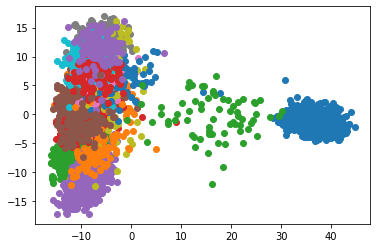

In [15]:
from numpy import unique,where

clusters = unique(prediction)
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(prediction == cluster)
    # create scatter of these samples
    plt.scatter(X_test_norm_100[row_ix, 0], X_test_norm_100[row_ix, 1])
# show the plot
plt.show()